Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

- How many different cases are there, by department?
- Does the percentage of cases that are late vary by department?
- On average, how late are the late cases by department?
- What is the service type that is the most late? Just for Parks & Rec?
- For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.
- Does whether or not its a weekend matter for when a case is opened/closed?
- On average, how many cases are opened a day for the Customer Service department?
- Does the number of service requests for the solid waste department vary by day of the week?

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

In [2]:
spark = SparkSession.builder.getOrCreate()

In [87]:
df = spark.read.csv('case.csv', header=True, inferSchema=True)
dept = spark.read.csv('dept.csv', header=True, inferSchema=True)
source = spark.read.csv('source.csv', header=True, inferSchema=True)

In [88]:
df.printSchema()

root
 |-- case_id: integer (nullable = true)
 |-- case_opened_date: string (nullable = true)
 |-- case_closed_date: string (nullable = true)
 |-- SLA_due_date: string (nullable = true)
 |-- case_late: string (nullable = true)
 |-- num_days_late: double (nullable = true)
 |-- case_closed: string (nullable = true)
 |-- dept_division: string (nullable = true)
 |-- service_request_type: string (nullable = true)
 |-- SLA_days: double (nullable = true)
 |-- case_status: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- request_address: string (nullable = true)
 |-- council_district: integer (nullable = true)



In [89]:
dept.printSchema()

root
 |-- dept_division: string (nullable = true)
 |-- dept_name: string (nullable = true)
 |-- standardized_dept_name: string (nullable = true)
 |-- dept_subject_to_SLA: string (nullable = true)



In [90]:
source.printSchema()

root
 |-- source_id: string (nullable = true)
 |-- source_username: string (nullable = true)



In [91]:
df = (
df.join(dept, 'dept_division', 'left')        
    .drop(dept.dept_division)
    .drop(dept.dept_name)
#     .drop(df.dept_division)
    .withColumnRenamed("standardized_dept_name", "department")
    # convert to a boolean
    .withColumn("dept_subject_to_SLA", col("dept_subject_to_SLA") == "YES")
)

In [92]:
df = (
    df.withColumn("case_closed", expr('case_closed == "YES"'))
    .withColumn("case_late", expr('case_late == "YES"'))
    .withColumn("council_district", col("council_district").cast("string"))
)

In [93]:
df.printSchema()

root
 |-- dept_division: string (nullable = true)
 |-- case_id: integer (nullable = true)
 |-- case_opened_date: string (nullable = true)
 |-- case_closed_date: string (nullable = true)
 |-- SLA_due_date: string (nullable = true)
 |-- case_late: boolean (nullable = true)
 |-- num_days_late: double (nullable = true)
 |-- case_closed: boolean (nullable = true)
 |-- service_request_type: string (nullable = true)
 |-- SLA_days: double (nullable = true)
 |-- case_status: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- request_address: string (nullable = true)
 |-- council_district: string (nullable = true)
 |-- department: string (nullable = true)
 |-- dept_subject_to_SLA: boolean (nullable = true)



In [19]:
df.show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 1/1/18 0:42          
 case_closed_date     | 1/1/18 12:29         
 SLA_due_date         | 9/26/20 0:42         
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 5                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only showing top 1 row



In [20]:
df = df.withColumnRenamed('SLA_due_date', 'case_due_date')
df = df.withColumnRenamed('SLA_days', 'case_days')

In [22]:
fmt = "M/d/yy H:mm"
df = (
    df.withColumn("case_opened_date", to_timestamp("case_opened_date", fmt))
    .withColumn("case_closed_date", to_timestamp("case_closed_date", fmt))
    .withColumn("case_due_date", to_timestamp("case_due_date", fmt))
)

In [24]:
df.printSchema()

root
 |-- case_id: integer (nullable = true)
 |-- case_opened_date: timestamp (nullable = true)
 |-- case_closed_date: timestamp (nullable = true)
 |-- case_due_date: timestamp (nullable = true)
 |-- case_late: boolean (nullable = true)
 |-- num_days_late: double (nullable = true)
 |-- case_closed: boolean (nullable = true)
 |-- service_request_type: string (nullable = true)
 |-- case_days: double (nullable = true)
 |-- case_status: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- request_address: string (nullable = true)
 |-- council_district: string (nullable = true)
 |-- department: string (nullable = true)
 |-- dept_subject_to_SLA: boolean (nullable = true)



How many different cases are there, by department?

In [28]:
df.groupby('department').count().show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



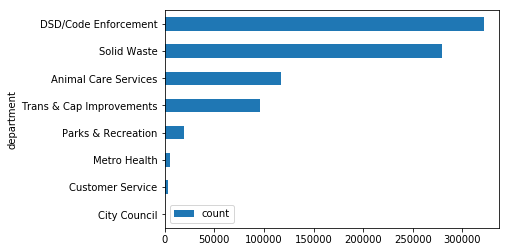

In [44]:
(
df
    .groupby('department')
    .count()
    .toPandas()
    .set_index('department')
    .sort_values('count')
    .plot.barh()
)

Does the percentage of cases that are late vary by department?

In [46]:
df.printSchema()

root
 |-- case_id: integer (nullable = true)
 |-- case_opened_date: timestamp (nullable = true)
 |-- case_closed_date: timestamp (nullable = true)
 |-- case_due_date: timestamp (nullable = true)
 |-- case_late: boolean (nullable = true)
 |-- num_days_late: double (nullable = true)
 |-- case_closed: boolean (nullable = true)
 |-- service_request_type: string (nullable = true)
 |-- case_days: double (nullable = true)
 |-- case_status: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- request_address: string (nullable = true)
 |-- council_district: string (nullable = true)
 |-- department: string (nullable = true)
 |-- dept_subject_to_SLA: boolean (nullable = true)



In [83]:
(
df.where(df.case_late == True)
    .groupby("department")
    .count()
).show(vertical=True)

-RECORD 0--------------------------
 department | Solid Waste          
 count      | 32945                
-RECORD 1--------------------------
 department | Animal Care Services 
 count      | 23276                
-RECORD 2--------------------------
 department | Trans & Cap Impro... 
 count      | 5411                 
-RECORD 3--------------------------
 department | Parks & Recreation   
 count      | 3797                 
-RECORD 4--------------------------
 department | Customer Service     
 count      | 2010                 
-RECORD 5--------------------------
 department | Metro Health         
 count      | 829                  
-RECORD 6--------------------------
 department | DSD/Code Enforcement 
 count      | 26235                

